In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

8783
8783
8783
8783
8783


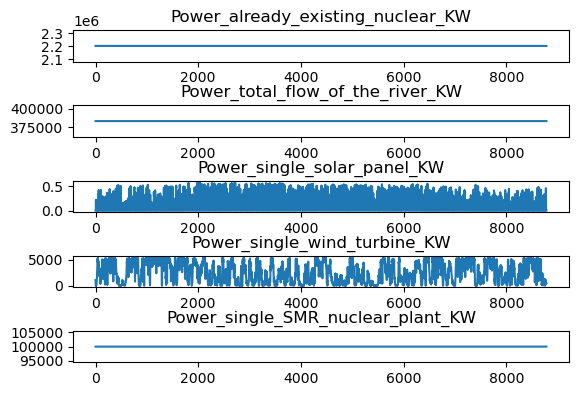

In [2]:
#from excels to numpy arrays

Power_total_demand_KW             = pd.read_excel('Power_total_demand_KW.xlsx').to_numpy()

Power_already_existing_nuclear_KW = pd.read_excel('Power_already_existing_nuclear_KW.xlsx').to_numpy()
Power_total_flow_of_the_river_KW  = pd.read_excel('Power_total_flow_of_the_river_KW.xlsx').to_numpy()

Power_single_solar_panel_KW       = pd.read_excel('Power_single_solar_panel_KW.xlsx').to_numpy()
Power_single_wind_turbine_KW      = pd.read_excel('Power_single_wind_turbine_KW.xlsx').to_numpy()
Power_single_SMR_nuclear_plant_KW = pd.read_excel('Power_single_SMR_nuclear_plant_KW.xlsx').to_numpy()

#debugging

print (Power_already_existing_nuclear_KW.size)
print (Power_total_flow_of_the_river_KW.size)
print (Power_single_solar_panel_KW.size)
print (Power_single_wind_turbine_KW.size)
print (Power_single_SMR_nuclear_plant_KW.size)

figure=plt.figure()

figure.add_subplot(10,1,1).title.set_text('Power_already_existing_nuclear_KW')
plt.plot(Power_already_existing_nuclear_KW)

figure.add_subplot(10,1,3).title.set_text('Power_total_flow_of_the_river_KW')
plt.plot(Power_total_flow_of_the_river_KW) 

figure.add_subplot(10,1,5).title.set_text('Power_single_solar_panel_KW')
plt.plot(Power_single_solar_panel_KW) 

figure.add_subplot(10,1,7).title.set_text('Power_single_wind_turbine_KW')
plt.plot(Power_single_wind_turbine_KW) 

figure.add_subplot(10,1,9).title.set_text('Power_single_SMR_nuclear_plant_KW')
plt.plot(Power_single_SMR_nuclear_plant_KW) 



In [3]:
# money stuff
investment_per_capita=2000;                       # €/person
population=14.691e6;                              # persons
total_investment=investment_per_capita*population;# €

cost_per_solar_panel_550w=600;                    # €
cost_per_wind_turbine_5Mw=6.5e6;                  # €
cost_per_nuclear_SMR100Mw=500e6;                  # €

max_N_nuclearSMR_plants =np.floor(total_investment/cost_per_nuclear_SMR100Mw);
max_N_wind_turbines     =np.floor(total_investment/cost_per_wind_turbine_5Mw);

print(max_N_nuclearSMR_plants)
print(max_N_wind_turbines)

58.0
4520.0


In [4]:
# simple multiplications, returning total power generation of birmingam 
# for specific number of nuclear ,wind ,and solar plants, except the fucking water storage thing

Power_total_SMR_nuclear_plant_KW   =np.zeros((Power_already_existing_nuclear_KW.size,1))
Power_total_wind_turbine_KW        =np.zeros((Power_already_existing_nuclear_KW.size,1))
Power_total_solar_panel_KW         =np.zeros((Power_already_existing_nuclear_KW.size,1))

def powerGeneration(N_nuclearSMR_plants,N_wind_turbines,N_solar_panels):
    global Power_total_SMR_nuclear_plant_KW   
    global Power_total_wind_turbine_KW        
    global Power_total_solar_panel_KW   

    Power_total_SMR_nuclear_plant_KW =N_nuclearSMR_plants * Power_single_SMR_nuclear_plant_KW ;
    Power_total_wind_turbine_KW      =N_wind_turbines     * Power_single_wind_turbine_KW;
    Power_total_solar_panel_KW       =N_solar_panels      * Power_single_solar_panel_KW;
    
    power_generated_result=                              \
        +Power_total_SMR_nuclear_plant_KW                \
        +Power_total_wind_turbine_KW                     \
        +Power_total_solar_panel_KW                      \
        +Power_already_existing_nuclear_KW               \
        +Power_total_flow_of_the_river_KW;
    
    return power_generated_result;

# https://matplotlib.org/2.0.2/examples/pylab_examples/stackplot_demo.html


In [5]:
# from demand and generation calculate the power generation of the water storage
    ## Hydro storage power plant 
    # This is a pumped-storage plant, with one upper and one lower reservoir. Water is supplied to the 
    # hydraulic machine (used as a turbine) during peak-hours (high electric demand) and is pumped 
    # during off-peak hours (minimum demand). 
    
upper_reservoir_capacity=1.3e7;                              #[m3]
initial_upper_reservoir_level=upper_reservoir_capacity*0.5;  #[m3]
lower_reservoir_capacity=2.28e7;                             #[m3]
average_head_H=762.5;                                        #[m]
    
    # Power plant equipped with 3 groups of turbopumps: Each group works as a 
    # turbine/generator when generating electricity and as an electricity consumer motor/pump 
    # for pumping water into the upper reservoir. 
    
displacement_pump    =8.67*60*60;     #[m3/h group]
displacement_turbine =10*60*60;    #[m3/h group]

power_hydro_pump     =75.67e3;         #[Kw/group]
power_hydro_turbine  =67.3e3;       #[Kw/group]
    
water_reservoir_level=np.zeros((Power_already_existing_nuclear_KW.size,1));
water_reservoir_level[0]=initial_upper_reservoir_level;

reservoir_generation=np.zeros((Power_already_existing_nuclear_KW.size,1));

numberofpumps_each_hour=np.zeros((Power_already_existing_nuclear_KW.size,1));
numberofturbines_each_hour=np.zeros((Power_already_existing_nuclear_KW.size,1));

def update_powerGeneration_added_water_from_storage(generation ,demand ,water_reservoir_level):
    global reservoir_generation
    global numberofpumps_each_hour
    global numberofturbines_each_hour
    
    for i in range(1, demand.size): #loop trough each hour of the year (starting on the second hour)
        power_balance = generation[i] - demand[i];
        
        if power_balance > 0:    #excess of energy in the mix
            n_pumps=howmany_pumps_should_we_turn_on(power_balance,water_reservoir_level[i-1]);
            water_reservoir_level[i] = water_reservoir_level[i-1] +  n_pumps*displacement_pump; #adding water 
            reservoir_generation[i]  = -n_pumps*power_hydro_pump;                               #removing power
            numberofpumps_each_hour[i]=n_pumps;
            
        elif power_balance < 0:  #lack of energy in the mix
            n_turbines=howmany_turbines_should_we_turn_on(power_balance,water_reservoir_level[i-1]);
            water_reservoir_level[i] = water_reservoir_level[i-1] - n_turbines*displacement_turbine;#removing water 
            reservoir_generation[i]  = +n_turbines*power_hydro_turbine;                             #adding power
            numberofturbines_each_hour[i]=n_turbines;
            
        elif power_balance == 0: #mix is balanced
            water_reservoir_level[i]=water_reservoir_level[i-1]; #no change in water
            reservoir_generation[i]=0;  #no energy generated
        
    return (generation+reservoir_generation);

In [6]:
#calculate how many pumps do we need to activate to consume the right ammount of power (maximum 3)
def howmany_pumps_should_we_turn_on( excess_power_ammount ,previous_water_level):

    if previous_water_level < upper_reservoir_capacity:               #there is still room to add water
        numberofpumps=min([(excess_power_ammount/power_hydro_pump),3]);
    else :
        #there is no water to fill
        numberofpumps=0;  
    return numberofpumps;

In [7]:
#calculate how many turbines do we need to activate to produce the right ammount of power emptying water (maximum 3)
def howmany_turbines_should_we_turn_on( lack_of_power_ammount ,previous_water_level):

    if previous_water_level >=0:                                       #there is still water to be wasted
        numberofturbines=min([(-lack_of_power_ammount/power_hydro_turbine),3]);
    else :
        #there is no water to empty
        numberofturbines=0;
        
    return numberofturbines;

In [8]:
total_gas_power=np.ones((Power_already_existing_nuclear_KW.size, 1));
total_spared_power=np.ones((Power_already_existing_nuclear_KW.size, 1));

power_mix_result=np.ones((Power_already_existing_nuclear_KW.size, 1));

# total power mix of birmingam to optimice
def calculateGas(numbers_of_nuclear_and_wind):
    
    global total_gas_power
    global total_spared_power
    global power_mix_result
    N_nuclearSMR_plants=np.floor(numbers_of_nuclear_and_wind[0]);
    N_wind_turbines    =np.floor(numbers_of_nuclear_and_wind[1]);
    
    total_nuclearSMR_cost   = N_nuclearSMR_plants *cost_per_nuclear_SMR100Mw;
    total_wind_turbines_cost= N_wind_turbines     *cost_per_wind_turbine_5Mw;
    
    absurdGasNumber=9999999999999999999999999999999999999; #to cheat the optimicing function into not using this N_SMR and N_wind values.
    
    if ((total_nuclearSMR_cost+total_wind_turbines_cost)>total_investment):
        return absurdGasNumber
    else:
        #calculating number of solar panels from remaining money
        total_cost_solar_panels= total_investment-(total_nuclearSMR_cost+total_wind_turbines_cost);
        N_solar_panels         = np.floor(total_cost_solar_panels/cost_per_solar_panel_550w);
    
        generation = powerGeneration( N_nuclearSMR_plants, N_wind_turbines, N_solar_panels);
    
        generation = update_powerGeneration_added_water_from_storage( generation, Power_total_demand_KW, water_reservoir_level);
        
        power_mix_result=generation-Power_total_demand_KW;
    
    for i in range(0, Power_already_existing_nuclear_KW.size):  #np.clip( was doinf weird things
        if power_mix_result[i]>0:
            total_spared_power[i]=power_mix_result[i];
        elif power_mix_result[i]<0:
            total_gas_power[i]=-power_mix_result[i];
        else:
            total_spared_power[i]=0;
            total_spared_power[i]=0;
            
    return (np.sum(total_gas_power));

In [9]:
calculateGas([36.10291520978536, 1011.4094541911127])

10650343268.37146

In [10]:
calculateGas([24.60396737778426, 1639.778193685323])

11114811792.709187

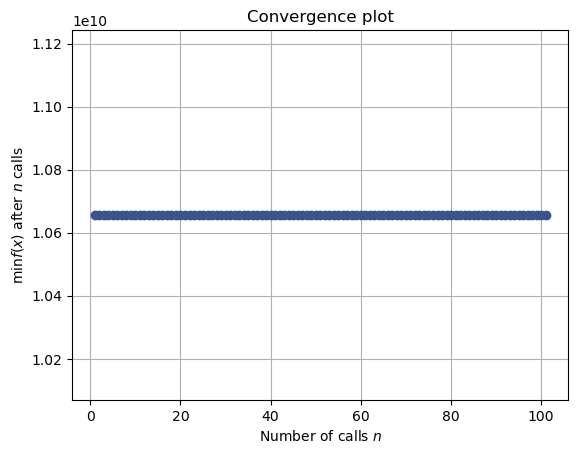

In [11]:
#This takes like 5 minutes

#https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html#sphx-glr-auto-examples-bayesian-optimization-py

from skopt import gp_minimize

numero_de_iteraciones=100;

best = gp_minimize(calculateGas, # function to minimize
                   [(0, max_N_nuclearSMR_plants),(0, max_N_wind_turbines)],# bounds on each dimension of x
                   acq_func="EI", # acquisition function
                   n_calls=numero_de_iteraciones+1, # number of evaluations of f
                   n_random_starts=numero_de_iteraciones, # number of random initialization points
                   x0=[36.10291520978536, 1011.4094541911127], # initial values
                   random_state=1234) # the random seed

from skopt.plots import plot_convergence
plot_convergence(best);

In [12]:
print(best.x)

#germany ban
#best.x=[0,1011.0];

[36.10291520978536, 1011.4094541911127]


In [13]:
resultado=calculateGas(best.x) #[36.10291520978536, 1011.4094541911127]
resultado/1000000 #in MW

15824.310711111397

In [14]:
def calculate_remaining_money(numbers_of_nuclear_and_wind):

    N_nuclearSMR_plants=np.floor(numbers_of_nuclear_and_wind[0]);
    N_wind_turbines    =np.floor(numbers_of_nuclear_and_wind[1]);
    
    total_nuclearSMR_cost   = N_nuclearSMR_plants *cost_per_nuclear_SMR100Mw;
    total_wind_turbines_cost= N_wind_turbines     *cost_per_wind_turbine_5Mw;
    
    absurdGasNumber=9999999999999999999999999999999999999; #to cheat the optimicing function into not using this N_SMR and N_wind values.
    
    if ((total_nuclearSMR_cost+total_wind_turbines_cost)>total_investment):
        return absurdGasNumber
    else:
        #calculating number of solar panels from remaining money
        total_cost_solar_panels= total_investment-(total_nuclearSMR_cost+total_wind_turbines_cost);
        N_solar_panels         = np.floor(total_cost_solar_panels/cost_per_solar_panel_550w);
        
        return total_investment-(total_nuclearSMR_cost+total_wind_turbines_cost+N_solar_panels*cost_per_solar_panel_550w)

In [15]:
calculate_remaining_money((best.x))

0.0

In [16]:
def calculate_number_of_all(numbers_of_nuclear_and_wind):

    N_nuclearSMR_plants=np.floor(numbers_of_nuclear_and_wind[0]);
    N_wind_turbines    =np.floor(numbers_of_nuclear_and_wind[1]);
    
    total_nuclearSMR_cost   = N_nuclearSMR_plants *cost_per_nuclear_SMR100Mw;
    total_wind_turbines_cost= N_wind_turbines     *cost_per_wind_turbine_5Mw;
    
    absurdGasNumber=9999999999999999999999999999999999999; #to cheat the optimicing function into not using this N_SMR and N_wind values.
    
    if ((total_nuclearSMR_cost+total_wind_turbines_cost)>total_investment):
        return absurdGasNumber
    else:
        #calculating number of solar panels from remaining money
        total_cost_solar_panels= total_investment-(total_nuclearSMR_cost+total_wind_turbines_cost);
        N_solar_panels         = np.floor(total_cost_solar_panels/cost_per_solar_panel_550w);
        
        return [N_nuclearSMR_plants, N_wind_turbines, N_solar_panels]

In [17]:
MAGICNUMBERS=calculate_number_of_all((best.x))
MAGICNUMBERS

[36.0, 1011.0, 8017500.0]

In [18]:
def display_budget_pie_chart(numbers_of_nuclear_and_wind_and_solar):

    N_nuclearSMR_plants=np.floor(numbers_of_nuclear_and_wind_and_solar[0]);
    N_wind_turbines    =np.floor(numbers_of_nuclear_and_wind_and_solar[1]);
    N_solar_pannels    =np.floor(numbers_of_nuclear_and_wind_and_solar[2]);
    
    total_nuclearSMR_cost   = N_nuclearSMR_plants *cost_per_nuclear_SMR100Mw;
    total_wind_turbines_cost= N_wind_turbines     *cost_per_wind_turbine_5Mw;
    total_solar_pannels_cost= N_solar_pannels     *cost_per_solar_panel_550w;
    
    remaining_money=total_investment-(total_nuclearSMR_cost+total_wind_turbines_cost+total_solar_pannels_cost)
    
    pievariables=np.array([total_nuclearSMR_cost, total_wind_turbines_cost, total_solar_pannels_cost, remaining_money])
    mylabels = ["Nuclear", "Wind", "Solar", "Remaining_money"]
    myexplode = [0.01, 0.01, 0.01, 0.01]
    
    figure=plt.figure()
    plt.title('Proportion of the investment spent in each energy source')
    plt.pie(pievariables ,labels = mylabels,explode = myexplode,autopct='%1.1f%%')
    print("remaining_money €",remaining_money)

In [19]:
def display_generation_pie_chart(numbers_of_nuclear_and_wind_and_solar):

    N_nuclearSMR_plants=np.floor(numbers_of_nuclear_and_wind_and_solar[0]);
    N_wind_turbines    =np.floor(numbers_of_nuclear_and_wind_and_solar[1]);
    N_solar_pannels    =np.floor(numbers_of_nuclear_and_wind_and_solar[2]);
    
    scalar_total_power_SMR_nuclear_plant_KW = N_nuclearSMR_plants *np.sum(Power_single_SMR_nuclear_plant_KW);
    scalar_total_power_wind_turbines_KW        = N_wind_turbines     *np.sum(Power_single_wind_turbine_KW);
    scalar_total_solar_pannels_KW              = N_solar_pannels     *np.sum(Power_single_solar_panel_KW);
    scalar_total_power_preexisting_nuclear_plant_KW = np.sum(Power_already_existing_nuclear_KW);
    scalar_total_preexisting_hydro_KW               = np.sum(Power_total_flow_of_the_river_KW);
    
    scalar_total_water_storage_KW                   = np.sum(np.clip(reservoir_generation,0,9999999999999999999999999999999999999));
    
    scalar_total_gas_KW                             = np.sum(total_gas_power);
    
    pievariables=np.array([scalar_total_power_SMR_nuclear_plant_KW,\
                           scalar_total_power_wind_turbines_KW, \
                           scalar_total_solar_pannels_KW, \
                           scalar_total_power_preexisting_nuclear_plant_KW,\
                           scalar_total_preexisting_hydro_KW,\
                           scalar_total_gas_KW,\
                           scalar_total_water_storage_KW
                          ])
    
    mylabels = ["Nuclear_SMR", "Wind", "Solar", "preexisting_NUCLEAR","preexisting_hydro","gas","water_storage"]
    myexplode = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01,0.01]
    
    figure=plt.figure()
    plt.title('What proportion of each source for each KW')
    plt.pie(pievariables ,labels = mylabels,explode = myexplode,autopct='%1.1f%%')

In [20]:
def display_money_per_kw_bar_chart(numbers_of_nuclear_and_wind_and_solar):

    N_nuclearSMR_plants=np.floor(numbers_of_nuclear_and_wind_and_solar[0]);
    N_wind_turbines    =np.floor(numbers_of_nuclear_and_wind_and_solar[1]);
    N_solar_pannels    =np.floor(numbers_of_nuclear_and_wind_and_solar[2]);
    
    scalar_total_power_SMR_nuclear_plant_KW = N_nuclearSMR_plants *np.sum(Power_single_SMR_nuclear_plant_KW);
    scalar_total_power_wind_turbines_KW        = N_wind_turbines     *np.sum(Power_single_wind_turbine_KW);
    scalar_total_solar_pannels_KW              = N_solar_pannels     *np.sum(Power_single_solar_panel_KW);
    
    total_nuclearSMR_cost   = N_nuclearSMR_plants *cost_per_nuclear_SMR100Mw;
    total_wind_turbines_cost= N_wind_turbines     *cost_per_wind_turbine_5Mw;
    total_solar_pannels_cost= N_solar_pannels     *cost_per_solar_panel_550w;
    
    source_names=['Nuclear_SMR','Wind','Solar'];
    cost_per_KW=[scalar_total_power_SMR_nuclear_plant_KW /total_nuclearSMR_cost,    \
                 scalar_total_power_wind_turbines_KW     /total_wind_turbines_cost, \
                 scalar_total_solar_pannels_KW           /total_solar_pannels_cost]
    
    figure=plt.figure()
    plt.title('How much money per KW per source')

    plt.bar(source_names,cost_per_KW, align='center', alpha=0.5)
    for i, v in enumerate(cost_per_KW):
        plt.text(i-.25, v/cost_per_KW[i], "{:.2f}".format(cost_per_KW[i]), fontsize=18, color='w')#numbers in graphs


In [21]:
def display_CO2_emission_perKW_pie_chart(numbers_of_nuclear_and_wind_and_solar):

    N_nuclearSMR_plants=np.floor(numbers_of_nuclear_and_wind_and_solar[0]);
    N_wind_turbines    =np.floor(numbers_of_nuclear_and_wind_and_solar[1]);
    N_solar_pannels    =np.floor(numbers_of_nuclear_and_wind_and_solar[2]);
    
    scalar_total_power_SMR_nuclear_plant_KW = N_nuclearSMR_plants *np.sum(Power_single_SMR_nuclear_plant_KW);
    scalar_total_power_wind_turbines_KW        = N_wind_turbines     *np.sum(Power_single_wind_turbine_KW);
    scalar_total_solar_pannels_KW              = N_solar_pannels     *np.sum(Power_single_solar_panel_KW);
    scalar_total_power_preexisting_nuclear_plant_KW = np.sum(Power_already_existing_nuclear_KW);
    scalar_total_preexisting_hydro_KW               = np.sum(Power_total_flow_of_the_river_KW);
    
    scalar_total_water_storage_KW                   = np.sum(np.clip(reservoir_generation,0,9999999999999999999999999999999999999));
    
    scalar_total_gas_KW                             = np.sum(total_gas_power);

    nuclear_gramsofCO2eqKW =5; 
    wind_gramsofCO2eqKW    =13; 
    solar_gramsofCO2eqKW   =40; 
    hydro_gramsofCO2eqKW   =11; 
    gas_gramsofCO2eqKW     =490; 
    
    #this is wrong
    CO2pievariables=np.array([scalar_total_power_SMR_nuclear_plant_KW      *nuclear_gramsofCO2eqKW,\
                           scalar_total_power_wind_turbines_KW             *wind_gramsofCO2eqKW, \
                           scalar_total_preexisting_hydro_KW               *hydro_gramsofCO2eqKW ,\
                           scalar_total_gas_KW                             *gas_gramsofCO2eqKW, \
                           scalar_total_water_storage_KW                   *hydro_gramsofCO2eqKW,\
                           scalar_total_solar_pannels_KW                   *solar_gramsofCO2eqKW, \
                           scalar_total_power_preexisting_nuclear_plant_KW *nuclear_gramsofCO2eqKW\
                             ])
    
    totalKWgen=np.sum(np.array([scalar_total_power_SMR_nuclear_plant_KW    ,\
                           scalar_total_power_wind_turbines_KW             ,\
                           scalar_total_preexisting_hydro_KW               ,\
                           scalar_total_gas_KW                             ,\
                           scalar_total_water_storage_KW                   ,\
                           scalar_total_solar_pannels_KW                   ,\
                           scalar_total_power_preexisting_nuclear_plant_KW \
                           ]))
    
    
    CO2perKW=np.sum(CO2pievariables/totalKWgen)/1000;
    print("Kg of CO2 per KW",CO2perKW)
    
    mylabels = ["Nuclear_SMR", "Wind","preexisting_hydro","GAS","water_storage", "Solar", "preexisting_NUCLEAR"]
    myexplode = [0, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
    
    figure=plt.figure()
    plt.title('Proportion of CO2 emissions per source')
    plt.pie(CO2pievariables ,labels = mylabels,explode = myexplode , autopct='%1.1f%%',textprops={'fontsize': 10})


In [22]:
#1) Description of your team: organization and tasks.
    


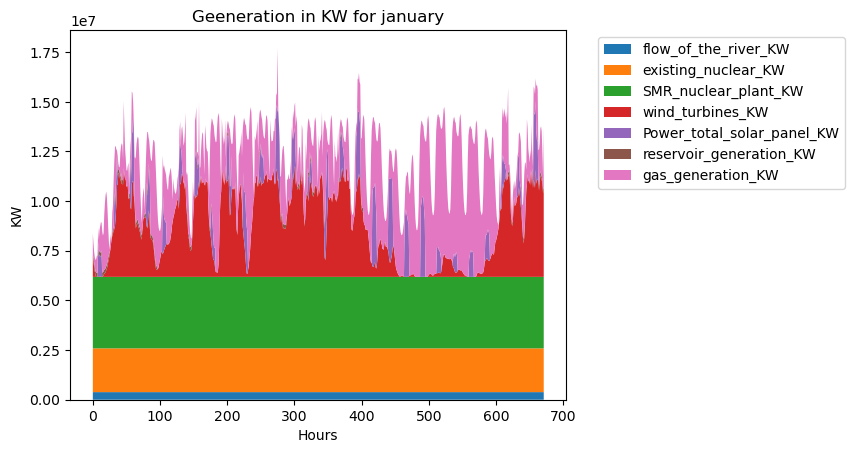

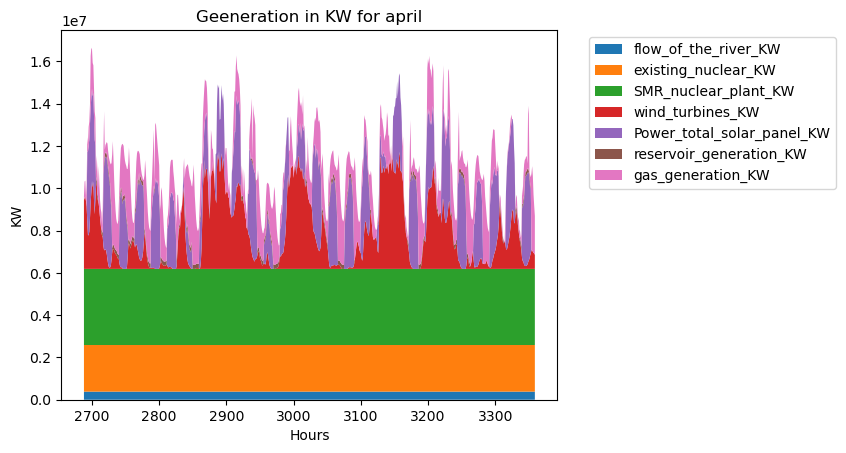

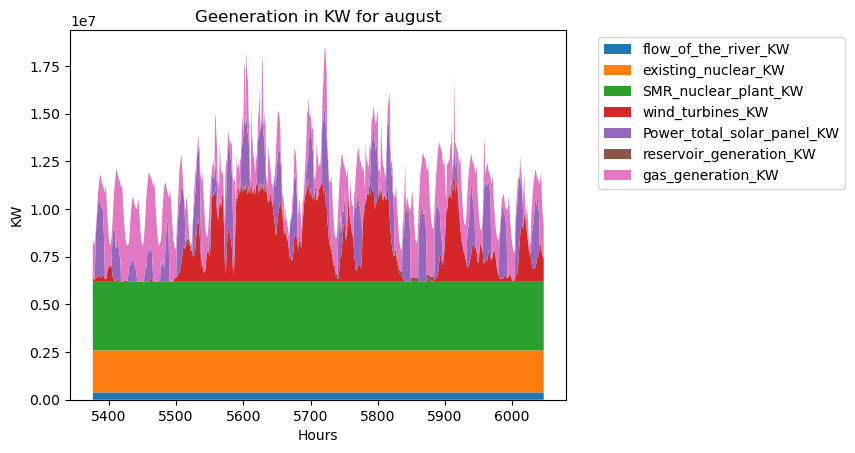

In [23]:
# 2) Plot of the generation of electricity as a function of time as a stackpile plot for different periods of the year. 
hours_start=0;#january
hours_end=24*7*4;#january
legend = ["flow_of_the_river_KW", "existing_nuclear_KW", "SMR_nuclear_plant_KW", "wind_turbines_KW", "Power_total_solar_panel_KW", "reservoir_generation_KW", "gas_generation_KW"]


figure=plt.figure()
plt.title('Geeneration in KW for january')
plt.xlabel('Hours')
plt.ylabel('KW')
stacked=plt.stackplot(range(hours_start, hours_end), \
                      Power_total_flow_of_the_river_KW[hours_start :hours_end].T, \
                      Power_already_existing_nuclear_KW[hours_start :hours_end].T, \
                      Power_total_SMR_nuclear_plant_KW[hours_start :hours_end].T, \
                      Power_total_wind_turbine_KW[hours_start :hours_end].T, \
                      Power_total_solar_panel_KW[hours_start :hours_end].T, \
                      np.clip(reservoir_generation,0,10e9)[hours_start :hours_end].T, \
                      total_gas_power[hours_start :hours_end].T, \
                      labels=legend)      
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


hours_start=24*7*4*4;#april
hours_end=24*7*4*5;#april

figure=plt.figure()
plt.title('Geeneration in KW for april')
plt.xlabel('Hours')
plt.ylabel('KW')
stacked=plt.stackplot(range(hours_start, hours_end), \
                      Power_total_flow_of_the_river_KW[hours_start :hours_end].T, \
                      Power_already_existing_nuclear_KW[hours_start :hours_end].T, \
                      Power_total_SMR_nuclear_plant_KW[hours_start :hours_end].T, \
                      Power_total_wind_turbine_KW[hours_start :hours_end].T, \
                      Power_total_solar_panel_KW[hours_start :hours_end].T, \
                      np.clip(reservoir_generation,0,10e9)[hours_start :hours_end].T, \
                      total_gas_power[hours_start :hours_end].T, \
                      labels=legend)  
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


hours_start=24*7*4*8;#august
hours_end=24*7*4*9;#august

figure=plt.figure()
plt.title('Geeneration in KW for august')
plt.xlabel('Hours')
plt.ylabel('KW')
stacked=plt.stackplot(range(hours_start, hours_end), \
                      Power_total_flow_of_the_river_KW[hours_start :hours_end].T, \
                      Power_already_existing_nuclear_KW[hours_start :hours_end].T, \
                      Power_total_SMR_nuclear_plant_KW[hours_start :hours_end].T, \
                      Power_total_wind_turbine_KW[hours_start :hours_end].T, \
                      Power_total_solar_panel_KW[hours_start :hours_end].T, \
                      np.clip(reservoir_generation,0,10e9)[hours_start :hours_end].T, \
                      total_gas_power[hours_start :hours_end].T, \
                      labels=legend)      

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


# plot reservoir levels aginst gas

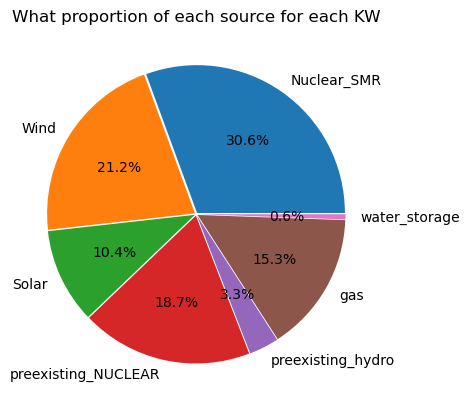

In [24]:
# 3) Plot of the final generation mix as a pie chart.
#https://app.electricitymaps.com/zone/GB
display_generation_pie_chart(MAGICNUMBERS) #water storage is okay


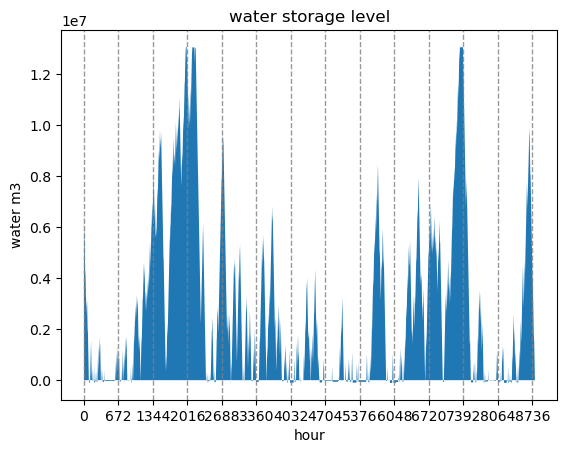

In [25]:
# 4) Plot of the evolution of the volume of water in hydro storage dams.
#TODO somthing is wrong here the water storage should not be negative,

figure=plt.figure()
ax = figure.add_subplot(1, 1, 1)
plt.title('water storage level')
plt.ylabel('water m3')
plt.xlabel('hour')
stacked=plt.stackplot(range(0, water_reservoir_level.size), water_reservoir_level.T)    
major_ticks = np.arange(0, water_reservoir_level.size, 24*7*4)#month grid

ax.set_xticks(major_ticks)

ax.grid(which='major', alpha=0.8, color='grey', linestyle='--', linewidth=1,axis='x')

In [26]:
# 5) Additional plots you might find interesting.



installed gas capacity is:  8074.392394580708  MW
average use of gas capacity is:  22.313724557225594 %


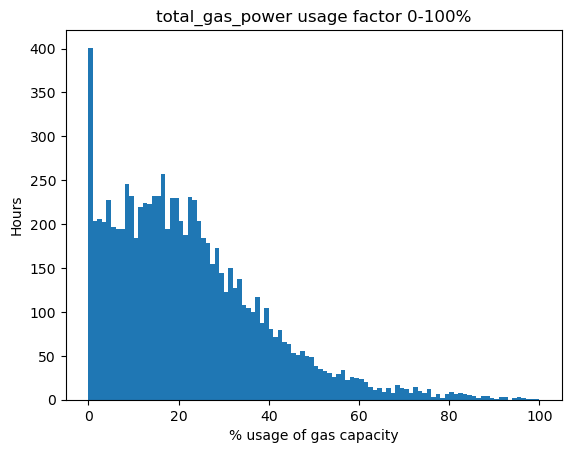

In [27]:
# 6) What are the load factor and the installed capacity of Combined cycle power plants?
#figure=plt.figure()
#plt.title('total_gas_power distribution')
#plt.hist(total_gas_power, density=False,bins=100)  # density=False would make counts
#plt.ylabel('Kw of gas')
#plt.xlabel('Hours');

print("installed gas capacity is: ",np.max(total_gas_power)/1000, " MW")

figure2=plt.figure()
plt.title('total_gas_power usage factor 0-100%')
plt.hist((total_gas_power/np.max(total_gas_power))*100, density=False,bins=100)  # density=False would make counts
plt.ylabel('Hours')
plt.xlabel('% usage of gas capacity');

print("average use of gas capacity is: ",np.mean((total_gas_power/np.max(total_gas_power))*100), "%")

In [28]:
total_gas_power

array([[1083050.20847549],
       [ 725172.35157802],
       [ 566098.35618768],
       ...,
       [4019941.06927195],
       [3438836.46162726],
       [2506540.42009331]])

In [29]:
total_gas_power/np.max(total_gas_power)

array([[0.13413396],
       [0.08981138],
       [0.07011034],
       ...,
       [0.49786298],
       [0.42589415],
       [0.31043084]])

In [30]:
np.max((total_gas_power/np.max(total_gas_power))*100)

100.0

remaining_money € 0.0


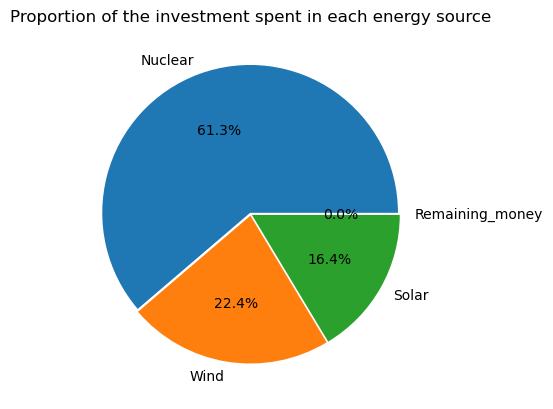

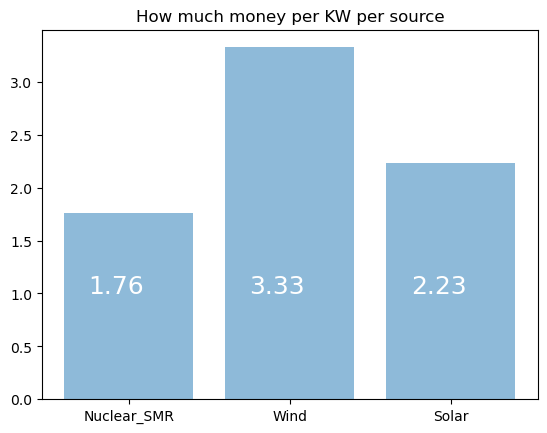

In [31]:
# Course Project: building an electricity generation mix Power systems
# 7) What is the share of wind, solar PV, and solar thermal investment 
display_budget_pie_chart(MAGICNUMBERS)
display_money_per_kw_bar_chart(MAGICNUMBERS)


Kg of CO2 per KW 0.08481070785285823


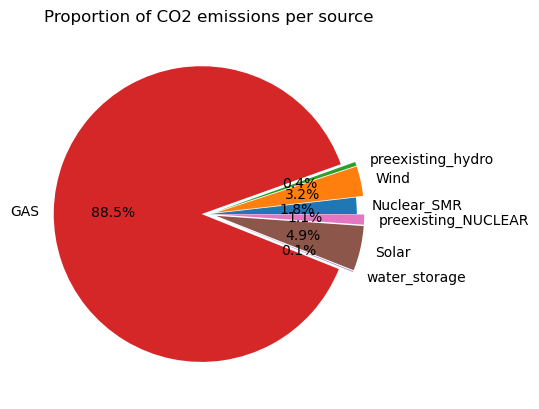

In [32]:
# 8) What are the emissions of CO2 per kwh generated? 
# google says 0.233 kgCO2e per kWh of electricity consumed.

display_CO2_emission_perKW_pie_chart(MAGICNUMBERS)



GW spared electricity 872.8576116092787


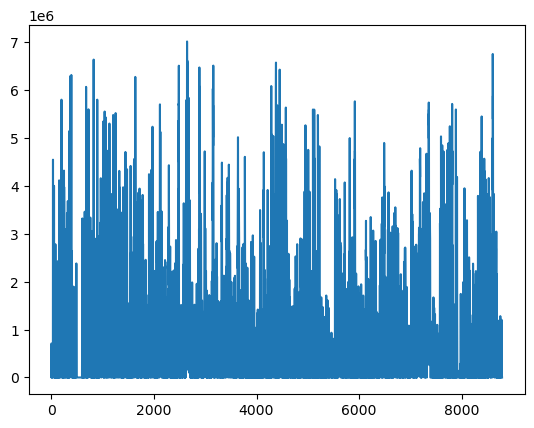

In [33]:
# 9) Were the wind mills or solar panels disconnected (production above demand)? If yes, how 
# much electricity was spared?



#figure=plt.figure()
#plt.plot(total_gas_power) # this means we didnt had enough power so we had to burn gas

figure=plt.figure()
plt.plot(total_spared_power) # this means we had spare power so we turned off renewables
print("GW spared electricity",np.sum(total_spared_power)/10e6)




max generation is in hour:  2647
max gas is in hour:  499


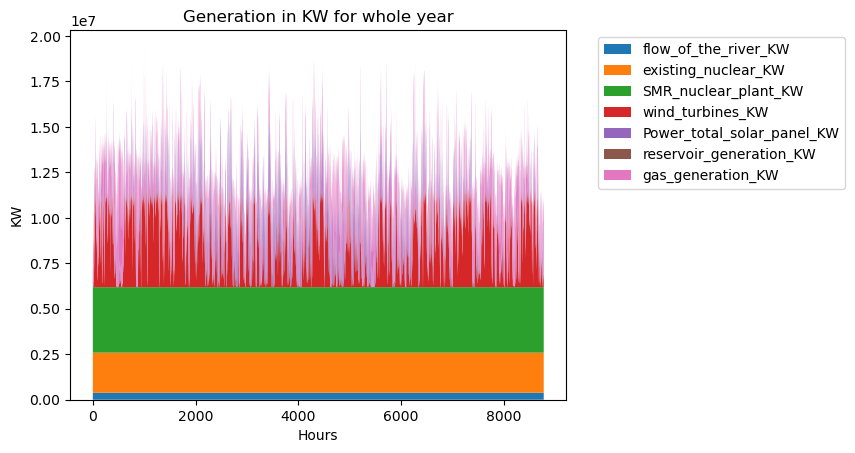

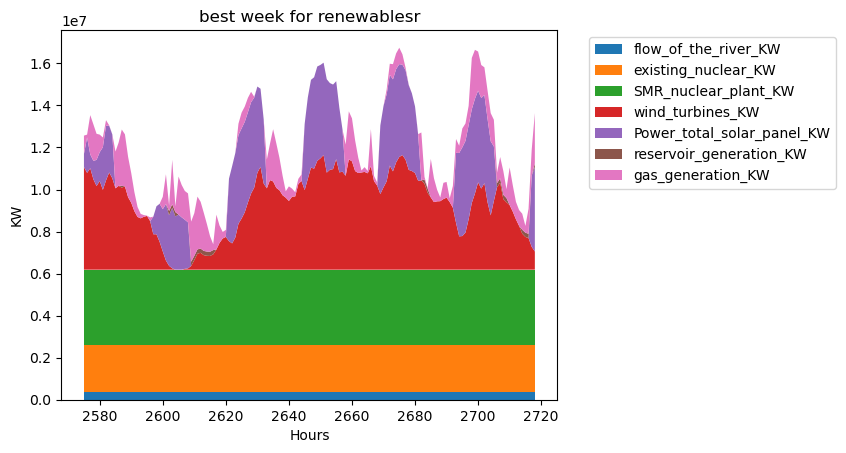

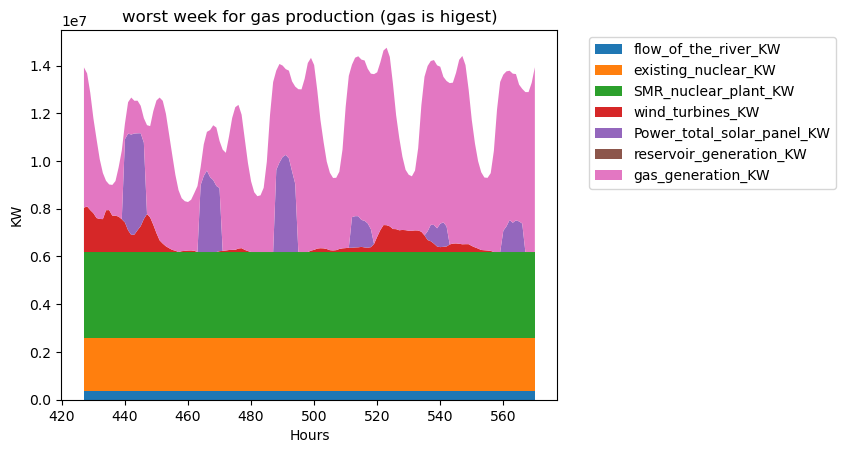

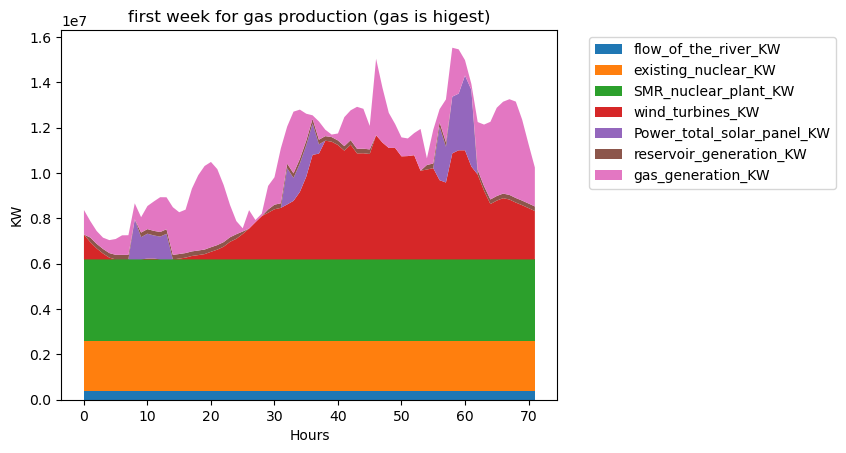

In [34]:
# 10) Evaluation of the resulting generation mix including a description of the strong and weak points. 


hours_start=0;#august
hours_end=Power_total_flow_of_the_river_KW.size;#august

figure=plt.figure()
plt.title('Generation in KW for whole year')
plt.xlabel('Hours')
plt.ylabel('KW')
stacked=plt.stackplot(range(hours_start, hours_end), \
                      Power_total_flow_of_the_river_KW[hours_start :hours_end].T, \
                      Power_already_existing_nuclear_KW[hours_start :hours_end].T, \
                      Power_total_SMR_nuclear_plant_KW[hours_start :hours_end].T, \
                      Power_total_wind_turbine_KW[hours_start :hours_end].T, \
                      Power_total_solar_panel_KW[hours_start :hours_end].T, \
                      np.clip(reservoir_generation,0,10e9)[hours_start :hours_end].T, \
                      total_gas_power[hours_start :hours_end].T, \
                      labels=legend)      

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

print("max generation is in hour: " ,total_spared_power.argmax())
print("max gas is in hour: " ,total_gas_power.argmax())


hours_start=total_spared_power.argmax()-24*3;#minus 3 days
hours_end=total_spared_power.argmax()+24*3;#plus 3 days

figure=plt.figure()
plt.title('best week for renewablesr')
plt.xlabel('Hours')
plt.ylabel('KW')
stacked=plt.stackplot(range(hours_start, hours_end), \
                      Power_total_flow_of_the_river_KW[hours_start :hours_end].T, \
                      Power_already_existing_nuclear_KW[hours_start :hours_end].T, \
                      Power_total_SMR_nuclear_plant_KW[hours_start :hours_end].T, \
                      Power_total_wind_turbine_KW[hours_start :hours_end].T, \
                      Power_total_solar_panel_KW[hours_start :hours_end].T, \
                      np.clip(reservoir_generation,0,10e9)[hours_start :hours_end].T, \
                      total_gas_power[hours_start :hours_end].T, \
                      labels=legend)      

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


hours_start=total_gas_power.argmax()-24*3;#minus 3 days
hours_end=total_gas_power.argmax()+24*3;#plus 3 days

figure=plt.figure()
plt.title('worst week for gas production (gas is higest)')
plt.xlabel('Hours')
plt.ylabel('KW')
stacked=plt.stackplot(range(hours_start, hours_end), \
                      Power_total_flow_of_the_river_KW[hours_start :hours_end].T, \
                      Power_already_existing_nuclear_KW[hours_start :hours_end].T, \
                      Power_total_SMR_nuclear_plant_KW[hours_start :hours_end].T, \
                      Power_total_wind_turbine_KW[hours_start :hours_end].T, \
                      Power_total_solar_panel_KW[hours_start :hours_end].T, \
                      np.clip(reservoir_generation,0,10e9)[hours_start :hours_end].T, \
                      total_gas_power[hours_start :hours_end].T, \
                      labels=legend)      

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

hours_start=0;#minus 3 days
hours_end=+24*3;#plus 3 days
figure=plt.figure()
plt.title('first week for gas production (gas is higest)')
plt.xlabel('Hours')
plt.ylabel('KW')
stacked=plt.stackplot(range(hours_start, hours_end), \
                      Power_total_flow_of_the_river_KW[hours_start :hours_end].T, \
                      Power_already_existing_nuclear_KW[hours_start :hours_end].T, \
                      Power_total_SMR_nuclear_plant_KW[hours_start :hours_end].T, \
                      Power_total_wind_turbine_KW[hours_start :hours_end].T, \
                      Power_total_solar_panel_KW[hours_start :hours_end].T, \
                      np.clip(reservoir_generation,0,10e9)[hours_start :hours_end].T, \
                      total_gas_power[hours_start :hours_end].T, \
                      labels=legend)      

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


In [35]:
# 11) Finally, you can calculate sensitivities with variation of some of the parameters or constraints 
# that will allow you to add some conclusions to the report. For instance, you can check what 
# happens if you increase the investment per capita or use different solar panels... Be 
# creative



In [36]:
#increasing 

In [39]:
print(Power_total_flow_of_the_river_KW[5011])
print(Power_already_existing_nuclear_KW[5011])
print(Power_total_SMR_nuclear_plant_KW[5011])
print(Power_total_wind_turbine_KW[5011])
print(Power_total_solar_panel_KW[5011])
print(np.clip(reservoir_generation,0,10e9)[5011])
print(total_gas_power[5011])
print(Power_total_demand_KW[5011])


[383220]
[2203650]
[3600000.]
[3880636.98276907]
[0.]
[65977.54223093]
[2637641.37107169]
[10133484.525]
